In [1]:
from google.colab import drive
drive.mount('/content/drive') 
import os
os.chdir(r"/content/drive/My Drive/app/RockUnet/")

Mounted at /content/drive


In [2]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization

In [3]:
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense
from tensorflow.keras import Model
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy,Precision,MeanIoU,Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,roc_curve,classification_report
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

In [4]:
def lr_scheduler(epoch, lr):
    if epoch > 5:
        lr = 0.00001
        return lr
    return lr

callbacks = [keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)]

In [15]:
def mobilnet_block (x, filters, strides):
    
    x = DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    return x

def mobilenet():
  #stem of the model
  K.set_image_data_format('channels_last')
  input = Input(shape = (224,224,3))
  x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  # main part of the model
  x = mobilnet_block(x, filters = 64, strides = 1)
  x = mobilnet_block(x, filters = 128, strides = 2)
  x = mobilnet_block(x, filters = 128, strides = 1)
  x = mobilnet_block(x, filters = 256, strides = 2)
  x = mobilnet_block(x, filters = 256, strides = 1)
  x = mobilnet_block(x, filters = 512, strides = 2)
  for _ in range (5):
       x = mobilnet_block(x, filters = 512, strides = 1)
  x = mobilnet_block(x, filters = 1024, strides = 2)
  x = mobilnet_block(x, filters = 1024, strides = 1)
  x = AvgPool2D (pool_size = 7, strides = 1, data_format='channels_last')(x)
  flatten = Flatten()(x)
  output = Dense (units = 3, activation = 'softmax')(flatten)
  model = Model(inputs=input, outputs=output)
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy','Recall',MeanIoU(num_classes=3),'Precision'])
  return model

In [14]:
def AlexNet():
  model = Sequential()

# 1st Convolutional Layer
  model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
  model.add(Activation('relu'))
# Max Pooling 
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
  model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))
# Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
  model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))

# 4th Convolutional Layer
  model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))

# 5th Convolutional Layer
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
  model.add(Activation('relu'))
# Max Pooling
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
  model.add(Flatten())
# 1st Fully Connected Layer
  model.add(Dense(4096, input_shape=(224*224*3,)))
  model.add(Activation('relu'))
# Add Dropout to prevent overfitting
  model.add(Dropout(0.4))

# 2nd Fully Connected Layer
  model.add(Dense(4096))
  model.add(Activation('relu'))
# Add Dropout
  model.add(Dropout(0.4))

# 3rd Fully Connected Layer
  model.add(Dense(1000))
  model.add(Activation('relu'))
# Add Dropout
  model.add(Dropout(0.4))

# Output Layer
  model.add(Dense(3))
  model.add(Activation('softmax'))

# Compile the model
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(learning_rate=0.0001), metrics=['accuracy','Recall',MeanIoU(num_classes=3),'Precision'])
  return model

In [13]:
def VGG16():
  model = Sequential([
        Conv2D(filters=64, kernel_size=(3,3), activation='relu', dilation_rate=2,padding='same', input_shape=(512,512,3)),
     #   MaxPool2D(pool_size=(2,2), strides=2),
        BatchNormalization(axis=1),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu', dilation_rate=2,padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        BatchNormalization(axis=1),
        Conv2D(filters=128, kernel_size=(3,3), activation='relu', dilation_rate=1, padding='same'),
    #    MaxPool2D(pool_size=(2,2), strides=2),
        BatchNormalization(axis=1),
        Conv2D(filters=128, kernel_size=(3,3), activation='relu', dilation_rate=1, padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        BatchNormalization(axis=1),
        Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    #    MaxPool2D(pool_size=(2,2), strides=2),
        BatchNormalization(axis=1),
        Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    #    MaxPool2D(pool_size=(2,2), strides=2),
        BatchNormalization(axis=1),
        Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        BatchNormalization(axis=1),
        Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        BatchNormalization(axis=1),
        Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        BatchNormalization(axis=1),
        Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        BatchNormalization(axis=1),
        Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),

        BatchNormalization(axis=1),
        Dense(units=4096),
        BatchNormalization(axis=1),
        Dense(units=4096),
        BatchNormalization(axis=1),
        Flatten(),
        Dense(units=3, activation='softmax')
    ])
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy','Recall',MeanIoU(num_classes=3),'Precision'])
  return model

In [5]:
def MoonRockNet():
    K.set_image_data_format('channels_last')
    inputs = Input((512 , 512, 3))
    
    conv1 = Conv2D(64, (3, 3), activation='relu',dilation_rate=2, padding='same') (inputs)
    batch1 = BatchNormalization(axis=3)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu',dilation_rate=2, padding='same') (batch1)
    batch1 = BatchNormalization(axis=3)(conv1)
    pool1 = MaxPooling2D((2, 2))(batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu',dilation_rate=1, padding='same') (pool1)
    batch2 = BatchNormalization(axis=3)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu',dilation_rate=1,padding='same') (batch2)
    batch2 = BatchNormalization(axis=3)(conv2)
    pool2 = MaxPooling2D((2, 2))(batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=3)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=3)(conv3)
    conv33 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch33 = BatchNormalization(axis=3)(conv33)
    pool3 = MaxPooling2D((2, 2))(batch33)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=3)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=3)(conv4)
    conv43 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch43 = BatchNormalization(axis=3)(conv43)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)

    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (pool4)
    up6 = concatenate([up6, conv4], axis=3)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (up6)
    up7 = concatenate([up7, conv3], axis=3)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (up7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=3)(conv8)
    pool5 = MaxPooling2D(pool_size=(2, 2))(batch8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same') (pool5)
    batch9 = BatchNormalization(axis=3)(conv8)
    pool6 = MaxPooling2D(pool_size=(2, 2))(batch9)
   
    flatten1 =  Flatten()(pool6)
    dense2 = Dense(units=256, activation='relu')(flatten1)
    dense3 = Dense(units=3, activation='softmax')(dense2)
    

    model = Model(inputs=[inputs], outputs=[dense3])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy','Recall',MeanIoU(num_classes=3),'Precision'])

    return model

In [6]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

In [7]:
def plotImages(images_arr):
    figs, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
def ROC(predictions, test_batches):
  from sklearn.preprocessing import OneHotEncoder
  ohe = OneHotEncoder()
  transformed = ohe.fit_transform(test_batches.classes.reshape(-1,1))
  y_true = transformed.toarray()



  from sklearn.metrics import auc
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(3):
      fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), predictions.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
  from itertools import cycle
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
  lw = 2
# Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
  mean_tpr /= 3

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
  plt.figure()
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
      color="deeppink",
      linestyle=":",
      linewidth=4,
  )

  plt.plot(
      fpr["macro"],
      tpr["macro"],
      label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
      color="navy",
      linestyle=":",
      linewidth=4,
  )

  colors = cycle(["aqua", "darkorange", "cornflowerblue", "b" , "g", "r", "c"])
  for i, color in zip(range(3), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color=color,
          lw=lw,
          label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
      )

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic to 3 types of rock")
  plt.legend(loc="lower right")
  plt.show()

Found 111 images belonging to 3 classes.
Found 19 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

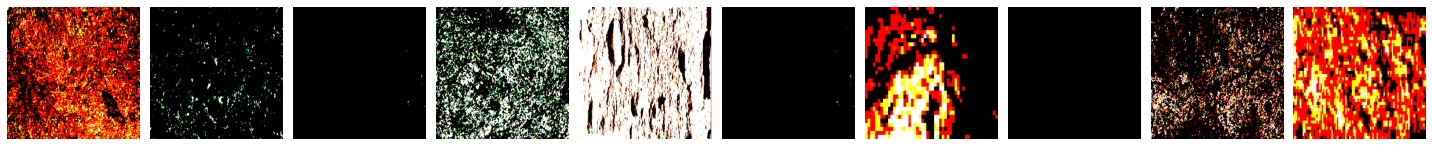

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_68 (Conv2D)             (None, 512, 512, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_91 (BatchN  (None, 512, 512, 64  256        ['con

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

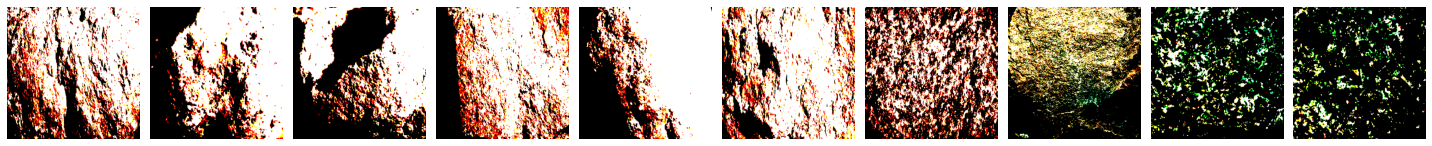

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.60      1.00      0.75         3
           2       1.00      0.33      0.50         6

    accuracy                           0.79        19
   macro avg       0.81      0.78      0.72        19
weighted avg       0.85      0.79      0.75        19

Confusion matrix, without normalization
[[10  0  0]
 [ 0  3  0]
 [ 2  2  2]]


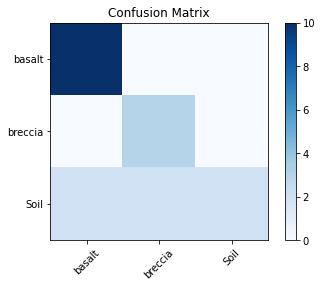

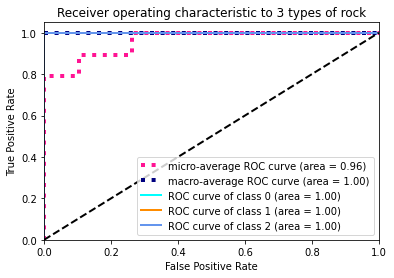

In [20]:
warnings.simplefilter(action='ignore', category=FutureWarning)

#Organize data into train, valid, test dirs
os.chdir(r"/content/drive/My Drive/app/RockUnet/")
os.chdir('dataset')
os.chdir('moon')

train_path = 'train'
test_path = 'test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(512,512), classes=['basalt','breccia','soil'],batch_size=10, shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(512,512), classes=['basalt','breccia','soil'],batch_size=10, shuffle=False)

#train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), classes=['basalt','breccia','soil'],batch_size=10, shuffle=True)
#test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), classes=['basalt','breccia','soil'],batch_size=10, shuffle=False)

assert train_batches.n == 111
assert test_batches.n == 19
assert train_batches.num_classes == test_batches.num_classes == 3

imgs, labels = next(train_batches)

plotImages(imgs)
print(labels)


#model = AlexNet()
#model = VGG16()
#model = mobilenet()
model = MoonRockNet()
model.summary()


model.fit(x=train_batches, epochs=10, callbacks=callbacks, verbose=2)

test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

predictions = model.predict(x=test_batches, verbose=0)

np.round(predictions)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

print(classification_report(test_batches.classes, np.argmax(predictions, axis=-1)))

    
cm_plot_labels = ['basalt','breccia','Soil']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

ROC(predictions, test_batches)
